In [1]:
import pandas as pd
from graph_tool import Graph
import numpy as np
import netpixi
from graph_tool import centrality
from graph_tool import clustering
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
from matplotlib import rcParams
from netpixi.data.gt import *

## Importando Dados

In [2]:
dataset = pd.read_csv('spotify_dataset.csv')
dataset.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

In [4]:
artist_dict = {}

for idx in dataset.index:
    
    artists = dataset['Artist'][idx]
    
    artists.replace('Tyler, The Creator', 'Tyler The Creator')
    
    artist = artists.split(', ')
    
    for e in artist:
        
        colabs = artist
        
        for art in colabs:
            if art == e:
                colabs.remove(art)
        
        generos = dataset['Genre'][idx].replace('[', '')
        generos = generos.replace(']', '')
        generos = generos.replace(', ', ',')
        generos = generos.replace("'", '')
        generos = generos.split(',')
        
        for g in generos:
                if g == '':
                    generos.remove(g)
        
        
        if e not in artist_dict:
            artist_dict[e] = {'num_musics': 1,
                              'streams': int(dataset['Streams'][idx].replace(',', '')),
                              'generos': generos,
                              'colabs': colabs}
        else:
            artist_dict[e]['num_musics'] += 1
            artist_dict[e]['streams'] += int(dataset['Streams'][idx].replace(',', ''))
            
            for g in generos:
                if g not in artist_dict[e]['generos']:
                    artist_dict[e]['generos'].append(g)
            
            for c in colabs:
                if c not in artist_dict[e]['colabs']:
                    artist_dict[e]['colabs'].append(c)
# artist_dict

## Criação do Grafo

In [5]:
g = Graph(directed=False) # não-dirigido pois numa colab não importa a ordem

g.vp['Nome_Artista'] = g.new_vp('object')
g.vp['Streams'] = g.new_vp('object')
g.vp['Colabs'] = g.new_vp('object')
g.vp['Generos'] = g.new_vp('object')

In [6]:
for artist in range(len(artist_dict)):
    g.add_vertex()
    
    nome = list(artist_dict.keys())[artist]
    
    g.vp['Nome_Artista'][artist] = nome
    g.vp['Streams'][artist] = artist_dict[nome]['streams']
    g.vp['Colabs'][artist] = artist_dict[nome]['colabs']
    g.vp['Generos'][artist] = artist_dict[nome]['generos']

In [7]:
artistas = list(artist_dict.keys())

for artista in artistas:
    index_artista_1 = artistas.index(artista)
    
    for artista_2 in artist_dict[artista]['colabs']:
        try:
            index_artista_2 = artistas.index(artista_2)
            
            e = g.edge(index_artista_1, index_artista_2, add_missing=False)
            
            if e == None and artista != artista_2:
                g.add_edge(index_artista_1, index_artista_2)
                
        except:
            pass

In [8]:
df = pd.DataFrame({k: list(v) for k, v in g.vp.items()})

df.head()

,Nome_Artista,Streams,Colabs,Generos
0,Måneskin,86402001,[],"[indie rock italiano, italian pop]"
1,The Kid LAROI,99132817,[],"[australian hip hop, ]"
2,Olivia Rodrigo,163685977,[],[pop]
3,Ed Sheeran,80580568,[],"[pop, uk pop]"
4,Lil Nas X,88772841,[Billy Ray Cyrus],"[lgbtq+ hip hop, pop rap]"


## Visualização da Rede

In [10]:
save_gt(g, 'spotfy.net.gz')
r = netpixi.render('spotfy.net.gz', infinite=True)

In [11]:
r.vertex_set_key('Nome_Artista')

In [12]:
grafo = load_gt('spotfy.net.gz')
m = draw_gt.sfdp_layout(grafo)
move_gt(grafo, m)
save_gt(grafo, 'exemplo.net.gz')
r = netpixi.render('exemplo.net.gz', infinite=True);

In [13]:
r.vertex_set_key('Nome_Artista')

## Cálculo das Centralidades

In [14]:
bc, _ = centrality.betweenness(grafo)

hcc = centrality.closeness(grafo, harmonic=True)

_, ec = centrality.eigenvector(grafo)

c = clustering.local_clustering(grafo)

dc = degree_gt(grafo)

In [15]:
grafo.vp['degree'] = dc

grafo.vp['betweenness'] = bc

grafo.vp['closeness'] = hcc

grafo.vp['eigenvector'] = ec

grafo.vp['clustering'] = c

In [16]:
df = pd.DataFrame({k: list(v) for k, v in grafo.vp.items()})
df.head()

,id,Nome_Artista,Streams,Colabs,Generos,_x,_y,degree,betweenness,closeness,eigenvector,clustering
0,0,Måneskin,86402001,[],"[indie rock italiano, italian pop]",46.449166,165.854544,0.000000,0.0,0.000000,0.000000,0.0
1,1,The Kid LAROI,99132817,[],"[australian hip hop, ]",14.067238,56.015647,0.001779,0.0,0.060606,0.001929,0.0
2,2,Olivia Rodrigo,163685977,[],[pop],-161.503617,-74.924265,0.000000,0.0,0.000000,0.000000,0.0
3,3,Ed Sheeran,80580568,[],"[pop, uk pop]",31.065850,-76.022125,0.000000,0.0,0.000000,0.000000,0.0
4,4,Lil Nas X,88772841,[Billy Ray Cyrus],"[lgbtq+ hip hop, pop rap]",143.691698,57.488905,0.000000,0.0,0.000000,0.000000,0.0


In [17]:
df.describe()

,id,Streams,_x,_y,degree,betweenness,closeness,eigenvector,clustering
count,563.000000,5.630000e+02,563.000000,563.000000,563.000000,563.000000,563.000000,5.630000e+02,563.000000
mean,281.000000,1.878026e+07,8.570324,18.969327,0.002434,0.000341,0.017038,1.099220e-02,0.086672
std,162.668374,3.644783e+07,93.744924,93.549295,0.005916,0.001491,0.030549,4.072243e-02,0.240495
min,0.000000,4.218201e+06,-186.298321,-176.786433,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,140.500000,5.112572e+06,-58.018871,-52.812138,0.000000,0.000000,0.000000,0.000000e+00,0.000000
50%,281.000000,6.985392e+06,1.407939,20.414630,0.000000,0.000000,0.000000,0.000000e+00,0.000000
75%,421.500000,1.518191e+07,80.235987,89.208313,0.001779,0.000000,0.008897,1.260064e-09,0.000000
max,562.000000,3.814805e+08,203.853118,214.816778,0.055160,0.012375,0.119187,3.299313e-01,1.000000


In [27]:
#incluimos as variaveis ln_degree e ln_betweenness para lidar com os casos em que essas variaveis são zero e ver se implicam num modelo melhor
df["ln_degree"] = np.log(df.degree)

df["ln_betweenness"] = np.log(df.betweenness)

df.replace(-np.inf, 0, inplace = True)

df.head()

,id,Nome_Artista,Streams,Colabs,Generos,_x,_y,degree,betweenness,closeness,eigenvector,clustering,ln_degree,ln_betweenness
1,1,The Kid LAROI,99132817,[],"[australian hip hop, ]",14.067238,56.015647,0.001779,0.000000,0.060606,0.001929,0.000000,-6.331502,0.000000
5,5,Doja Cat,145125833,[The Weeknd],"[dance pop, pop]",9.135109,33.797773,0.005338,0.005636,0.077629,0.019706,0.333333,-5.232890,-5.178547
6,6,Rauw Alejandro,102871195,"[Mr. Naisgai, Beéle, Mambo Kingz, DJ Luian, Da...","[puerto rican pop, trap latino, latin, reggaet...",-0.474889,15.837146,0.033808,0.008234,0.105753,0.186964,0.204678,-3.387063,-4.799463
7,7,Bad Bunny,340730660,"[J Balvin, Jhay Cortez, ROSALÍA, Dua Lipa, Jow...","[latin, reggaeton, trap latino, reggaeton colo...",-30.244075,28.494708,0.040925,0.010064,0.105363,0.238041,0.217391,-3.196008,-4.598811
8,8,Dua Lipa,114973848,[Angèle],"[dance pop, pop, uk pop]",-37.103978,29.437363,0.003559,0.000000,0.078902,0.044904,1.000000,-5.638355,0.000000


## Hipóteses

**H1:**

    - Intermediação (betweenness) tem relação com Sucesso_Artista (Streams). Quando um artista tem uma intermediação alta, significa que ele possui colabs com artistas de diferentes clusters na rede. Dessa forma as músicas que esse artista com alta intermediação lança, é acessada pela base de ouvintes dos diferentes clusters, aumentando assim seu sucesso.


**H2:**

    - Colab (degree) tem relação com Sucesso_Artista (Streams). A participação de um artista em colabs aumenta seu sucesso

## Análise Visual

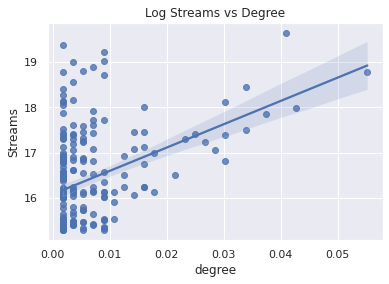

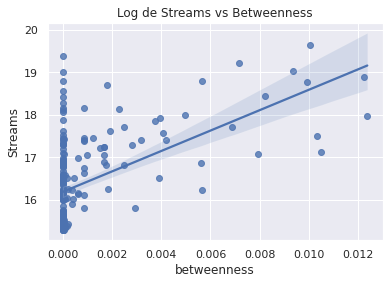

In [28]:

sns.set()

#Como os valores de Streams são muito maiores que os das centralidades utilizamos na regressão o Log de Streams
sns.regplot(x=df['degree'], y=np.log(df['Streams']))
plt.title("Log Streams vs Degree")
plt.show()


sns.regplot(x=df['betweenness'], y=np.log(df['Streams']))
plt.title("Log de Streams vs Betweenness")
plt.show()

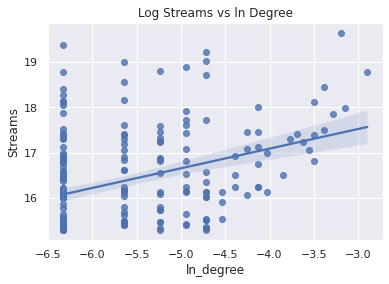

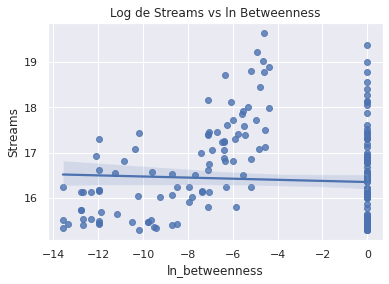

In [29]:
sns.regplot(x=df['ln_degree'], y=np.log(df['Streams']))
plt.title("Log Streams vs ln Degree")
plt.show()

sns.regplot(x=df['ln_betweenness'], y=np.log(df['Streams']))
plt.title("Log de Streams vs ln Betweenness")
plt.show()

## Análise dos Modelos

In [30]:
#Verificamos o quanto o ln de betweenness explica a variavel dependente
model = smf.ols(data=df, formula='np.log(Streams) ~ ln_betweenness')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        np.log(Streams)   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6752
Date:                Mon, 08 Nov 2021   Prob (F-statistic):              0.412
Time:                        13:58:32   Log-Likelihood:                -323.11
No. Observations:                 227   AIC:                             650.2
Df Residuals:                     225   BIC:                             657.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         16.3550      0.084    193.654      0.000      16.189      16.521
ln_betweenness    -0.0122      0.015     -0.822      0.412      -0.041       0.017
==============================================================================
Omnibus:                       29.461   Durbin-Watson:                   1.518
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.193
Skew:                           0.980   Prob(JB):                     8.39e-09
Kurtosis:                       3.300   Cond. No.                         7.25
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
#Verificamos o quanto o ln de degree explica a variavel dependente
model = smf.ols(data=df, formula='np.log(Streams) ~ ln_degree')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        np.log(Streams)   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     38.27
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           2.88e-09
Time:                        13:58:32   Log-Likelihood:                -305.63
No. Observations:                 227   AIC:                             615.3
Df Residuals:                     225   BIC:                             622.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.8261      0.397     47.363      0.000      18.043      19.609
ln_degree      0.4336      0.070      6.186      0.000       0.296       0.572
==============================================================================
Omnibus:                       32.821   Durbin-Watson:                   1.670
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.194
Skew:                           1.008   Prob(JB):                     6.88e-10
Kurtosis:                       3.632   Cond. No.                         37.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
#Utilizamos as 4 centralidades pois assim obtivemos o Maior valor de Rquadrado para nosso modelo de 20%
model = smf.ols(data=df, formula='np.log(Streams) ~ betweenness + degree + closeness + eigenvector') # Streams é explicada pelas centralidades?
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        np.log(Streams)   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     23.43
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           3.55e-16
Time:                        13:59:37   Log-Likelihood:                -283.47
No. Observations:                 227   AIC:                             576.9
Df Residuals:                     222   BIC:                             594.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      16.0482      0.115    139.285      0.000      15.821      16.275
betweenness   193.9745     38.363      5.056      0.000     118.372     269.577
degree         23.4603     23.421      1.002      0.318     -22.696      69.617
closeness       2.3512      2.247      1.046      0.297      -2.077       6.779
eigenvector    -2.0578      2.909     -0.707      0.480      -7.791       3.675
==============================================================================
Omnibus:                       36.782   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.688
Skew:                           1.040   Prob(JB):                     1.62e-11
Kurtosis:                       3.962   Cond. No.                         740.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        np.log(Streams)   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     46.00
Date:                Mon, 08 Nov 2021   Prob (F-statistic):           1.03e-10
Time:                        14:00:21   Log-Likelihood:                -302.34
No. Observations:                 227   AIC:                             608.7
Df Residuals:                     225   BIC:                             615.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.0868      0.076    210.687      0.000      15.936      16.237
degree        51.4428      7.585      6.783      0.000      36.497      66.389
==============================================================================
Omnibus:                       40.842   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.799
Skew:                           1.152   Prob(JB):                     4.64e-13
Kurtosis:                       3.834   Cond. No.                         124.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Análise H2:**
   - Ao observar o resultado do modelo, vemos que ele possui uma capacidade explicativa dos dados (R-squared) de aproximadamente 20%, após considerarmos todas as combinações de features as váriaveis de controle definidas foram as 4 centralidades. Tendo em vista esses resultados observamos que o betweenness possui uma coeficiente positivo com valor próximo de 33, contudo seu p-valor é de 7%, indicando uma relação positiva e não muito significativa, pois, estamos adotando um treshold de 5% para o p-valor.Dessa forma, rejeitamos H2.

**Análise H1:**
   - Para a variável betweenness, temos que seu coeficiente é de apriximadamente 182 e seu p-valor é menor que 0.001. Portanto, podemos concluir que há uma relação positiva e significativa entre o betweenness e Streams. Dessa forma, não rejeitamos H1.

### Explorando H2
Dado que inicialmente tivemos que rejeitar H2, continuamos investigando o dataset para ver se encontramos algum recorte que possa corroborar com H2. O recorte proposto é remover os artistas que nunca fizeram colab e então analisar apenas a relação de degree com streams para artistas com degree > 0. A hipótese é de que quanto maior a quantidade de colabs, maior será a quantidade de streams, desde que o artista faça pelo menos um colab, como em um efeito de prática.

In [ ]:
 df= df[df['degree'] != 0]
    

In [ ]:
sns.set()

#Como os valores de Streams são muito maiores que os das centralidades utilizamos na regressão o Log de Streams
sns.regplot(x=df['degree'], y=np.log(df['Streams']))
plt.title("Log Streams vs Degree")
plt.show()

In [ ]:

model = smf.ols(data=df, formula='np.log(Streams) ~ degree') # Streams é explicada pelas centralidades?
result = model.fit()
result.summary()

### Análise H2 com recorte
Excluindo vértices com degree = 0, obtivemos R-quadrado de 17% e p-valor 0. Também notamos uma relação positiva e significativa entre degree e streams. Dessa forma, não rejeitamos H2 para o recorte apresentado na mudança, após termos inicialmente rejeitado H2. 

## Resíduos

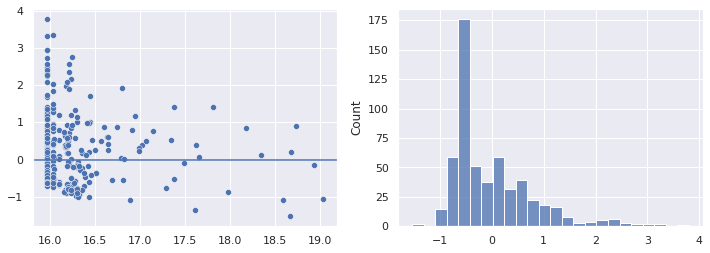

In [25]:
def linear_resplot(result):
    width, height = rcParams['figure.figsize']
    fig, axs = plt.subplots(1, 2, figsize=(2 * width, height))
    ax = sns.scatterplot(x=result.fittedvalues, y=result.resid, ax=axs[0])
    ax.axhline(0)
    sns.histplot(result.resid, ax=axs[1])
    plt.show()

linear_resplot(result)

Ao analisar os resíduos, observamos que sua distribuição não é normal e a variância dos erros não possuem um comportamento específico, dessa forma podemos concluir que o modelo não é homocedástico. Pode haver outras variáveis de controle que não incluimos no modelo e outras maneiras de tratamento dos dados, como subistituição dos zeros, criação de novas features, entre outras, que poderiam aumentar o poder explicativo do modelo.